link to the overleaf project: https://www.overleaf.com/project/617a720c541e5437e1633b5a

# Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib notebook

import matplotlib
matplotlib.rc('font', size=14)
from matplotlib.gridspec import GridSpec

import adaptive
adaptive.notebook_extension()

# Bifurcation diagram

<IPython.core.display.Javascript object>


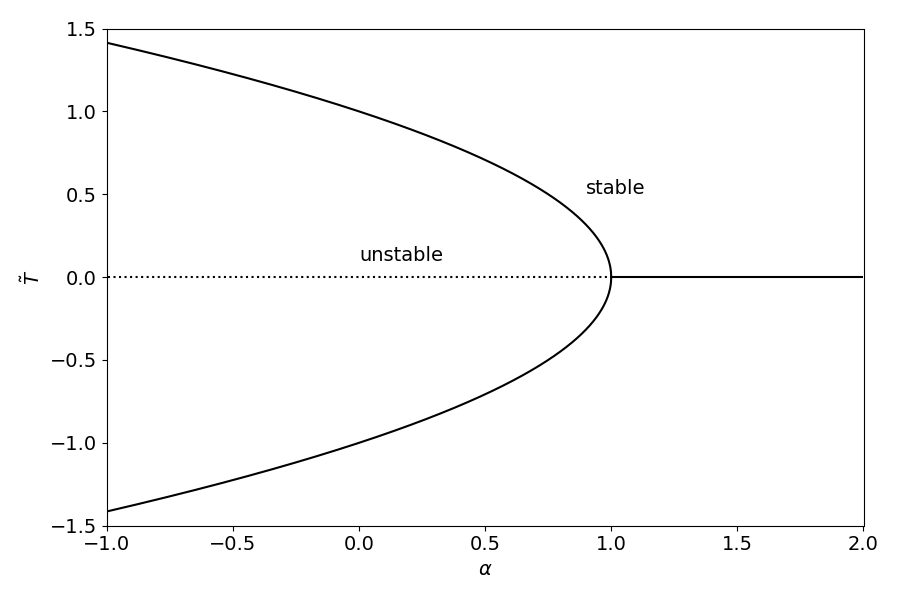

In [130]:
a = np.linspace(-2,1,3001)

fig,ax = plt.subplots(figsize=(9,6))

plt.plot(a, np.sqrt(1 - a), color='black')
plt.plot(a, -np.sqrt(1 - a), color='black')

plt.hlines([0], -2, 1, color='black', linestyle='dotted')
plt.hlines([0], 1, 2, color='black')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\tilde{T}$')

plt.xlim(-1,2)
plt.ylim(-1.5, 1.5)

plt.text(0.9, 0.5, 'stable')
plt.text(0., 0.1, 'unstable')

fig.tight_layout()

In [131]:
fig.savefig('bifurcation.pdf')

## Stability analysis

### Non-oscillating perturbations

<IPython.core.display.Javascript object>


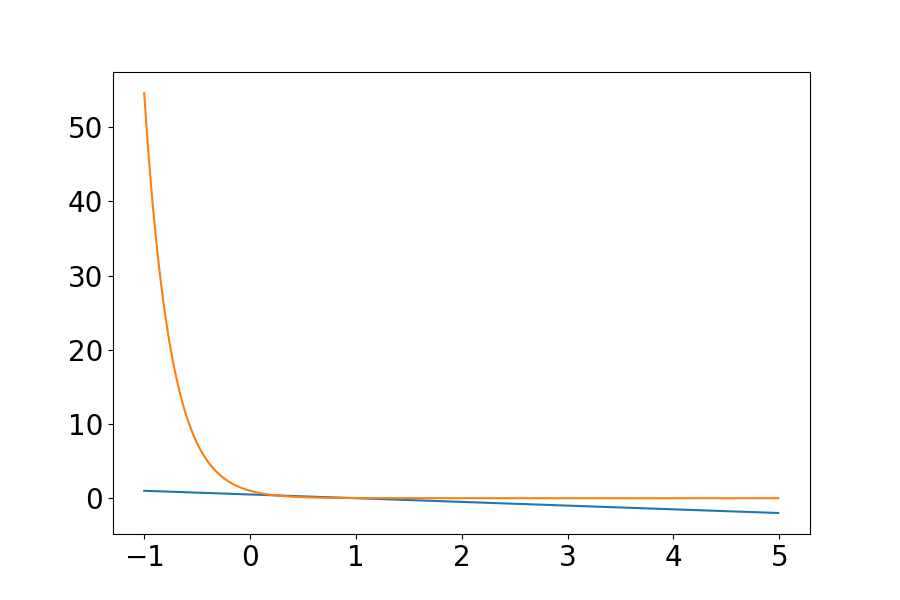

In [64]:
alpha = 2
delta = 4
# T = np.sqrt(1 - alpha)
T = 0

def f1(lamr):
    return (1 - 3*T**2 - lamr)/alpha

def f2(lamr):
    return np.exp(-delta*lamr)

fig,ax = plt.subplots(figsize=(9,6))

lamrs = np.arange(-1,5, 0.01)

plt.plot(lamrs, f1(lamrs))
plt.plot(lamrs, f2(lamrs))

### Oscillating solutions

In [24]:
from scipy.optimize import fsolve

In [75]:
alpha = 0.9
delta = 2
T = np.sqrt(1 - alpha)

def func(lam):
    lamr, lami = lam
    r = 1 - 3*T**2 - alpha*np.exp(-delta*lamr)*np.cos(lami*delta) - lamr
    i = alpha*np.exp(-delta*lamr)*np.sin(lami*delta) - lami
    
    return (r,i)

lam0 = (1,0)

fsolve(func, lam0)

array([2.93903444e-01, 9.24960570e-09])

### Analytical solution

<IPython.core.display.Javascript object>


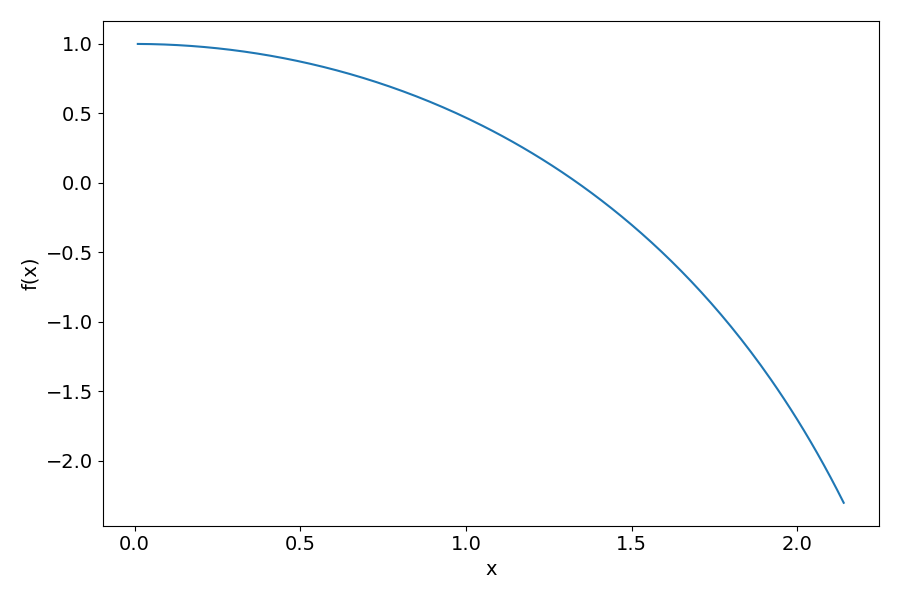

<ipython-input-23-7088c6949206>:2: RuntimeWarning: invalid value encountered in true_divide
  return np.log((np.sin(x)/x)) + x/np.tan(x)


In [23]:
def f(x):
    return np.log((np.sin(x)/x)) + x/np.tan(x)

xs = np.arange(0, np.pi-1, 0.01)

fig,ax = plt.subplots(figsize=(9,6))
plt.plot(xs, f(xs))

plt.xlabel('x')
plt.ylabel('f(x)')

fig.tight_layout()

<IPython.core.display.Javascript object>


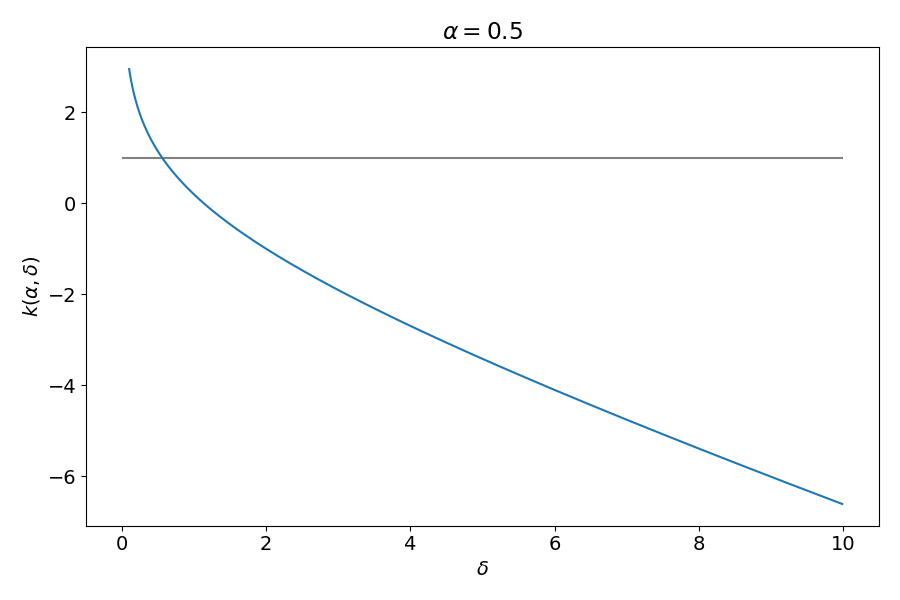

<ipython-input-13-719cbd63a91b>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.arccos((3*alpha - 2)/alpha)/np.sqrt(alpha**2 - (2 - 3*alpha)**2)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [22]:
alpha = 0.5
deltas = np.arange(0.1,10,0.01)

fig,ax = plt.subplots(figsize=(9,6))
plt.plot(deltas, deltas*(3*alpha - 2) - np.log(alpha*deltas))
plt.hlines([1], 0,10, color='gray')
plt.vlines([delta_crit(alpha)], *ax.get_ylim(), color='gray')

plt.xlabel(r'$\delta$')
plt.ylabel(r'$k(\alpha, \delta)$')

plt.title(r'$\alpha = %.1f$' %alpha)

fig.tight_layout()

In [124]:
def k(alpha, delta):
    return delta*(3*alpha - 2) - np.log(alpha*delta)

def solve(alphadelta):
    alpha, delta = alphadelta
    ka = k(alpha, delta)
#     print(ka)
    if ka > 1:
        y = 0
        def non_oscillating(x):
            return 3 - 2/alpha - x/(alpha*delta) - np.exp(-x)
        x = fsolve(non_oscillating, 0)[0]
        
    else:
        def oscillating(y):
            return f(y) - ka

        y = fsolve(oscillating, np.pi - 1e-4)[0]
#         y = fsolve(oscillating, 2, full_output=True)
#         print(y)
        if y < 0:
            y = -y
        x = np.log(alpha*delta*np.sin(y)/y)
    
    return x, y, 1/(x**2 + 1e-2)

In [64]:
delta_crit(0.9)

1.2015049158624418

In [125]:
solve((0.6, 10))

(0.5424837976432144, 2.3876001807880893, 3.286353046538977)

In [126]:
learner = adaptive.Learner2D(solve, bounds=[(0.4, 1), (0.1, 10)])

In [136]:
runner = adaptive.Runner(learner, goal = lambda l: l.loss() < 0.001)
runner.live_info()

In [179]:
xy = np.array(list(learner.data.keys()))
alphas, deltas = xy[:,0], xy[:,1]
vs = np.array(list(learner.data.values()))
xs = vs[:,0]
ys = vs[:,1]
qs = vs[:,2]

In [183]:
# grid search

alpha_s = np.arange(0.75, 1, 0.003)
delta_s = np.arange(0.1, 10, 0.01)

a_s = []
d_s = []
v_s = []

for alpha in tqdm(alpha_s):
    for delta in delta_s:
        a_s.append(alpha)
        d_s.append(delta)
        v_s.append(solve((alpha, delta)))
        
v_s = np.array(v_s)
x_s = list(v_s[:,0])
y_s = list(v_s[:,1])
q_s = list(v_s[:,2])

  0%|          | 0/84 [00:00<?, ?it/s]

In [184]:
alphas = np.array(list(alphas) + a_s)
deltas = np.array(list(deltas) + d_s)
xs = np.array(list(xs) + x_s)
ys = np.array(list(ys) + y_s)
qs = np.array(list(qs) + q_s)

<IPython.core.display.Javascript object>


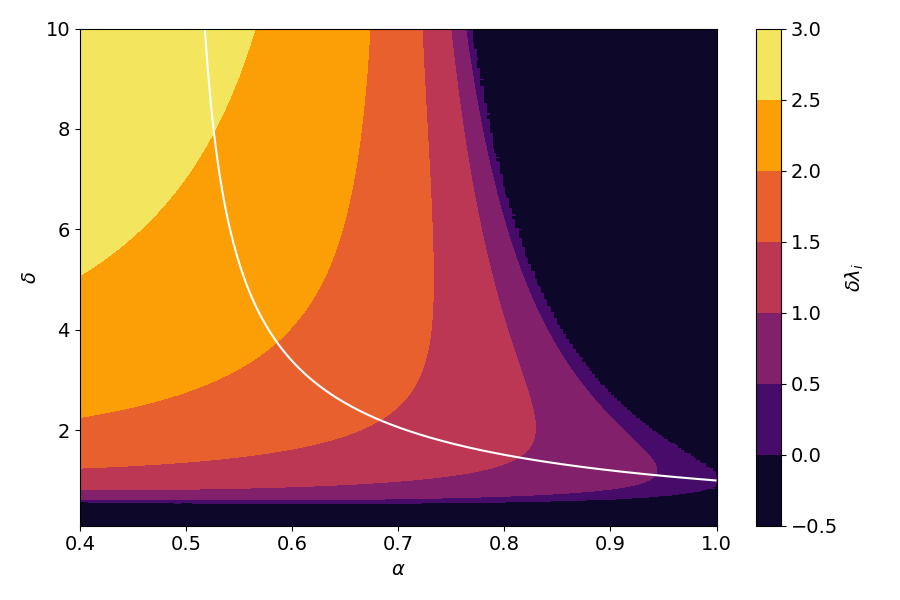

In [206]:
fig,ax = plt.subplots(figsize=(9,6))

# plt.tricontourf(alphas, deltas, xs, cmap='coolwarm', levels=np.linspace(-2, 2, 9))
plt.tricontourf(alphas, deltas, ys, cmap='inferno', levels=np.arange(-0.5, 3.5, 0.5)+1e-5)
plt.colorbar(label=r'$\delta \lambda_i$')

# plt.scatter(alphas, deltas, s=0.1)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')

ax.set_ylim(*ax.get_ylim())
alphass = np.arange(0.501, 1, 0.001)
plt.plot(alphass, [delta_crit(alpha) for alpha in alphass], color='white')



fig.tight_layout()

In [198]:
fig.savefig('stability_y.pdf')

<IPython.core.display.Javascript object>


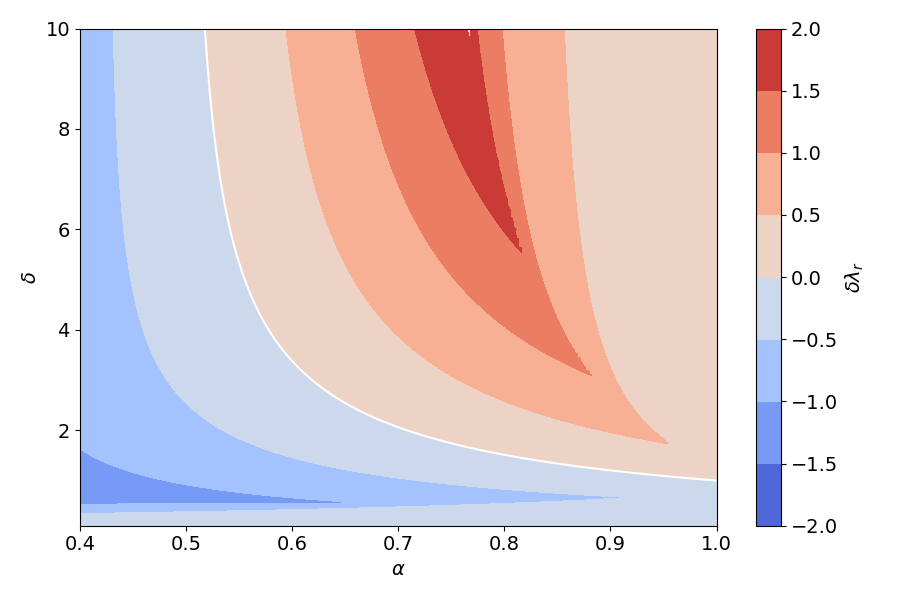

In [208]:
fig,ax = plt.subplots(figsize=(9,6))

plt.tricontourf(alphas, deltas, xs, cmap='coolwarm', levels=np.linspace(-2, 2, 9))
# plt.tricontourf(alphas, deltas, ys, cmap='inferno', levels=np.arange(-0.5, 3.5, 0.5)+1e-5)
plt.colorbar(label=r'$\delta \lambda_r$')

# plt.scatter(alphas, deltas, s=0.1)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')

ax.set_ylim(*ax.get_ylim())
alphass = np.arange(0.501, 1, 0.001)
plt.plot(alphass, [delta_crit(alpha) for alpha in alphass], color='white')



fig.tight_layout()

In [209]:
fig.savefig('stability_x.pdf')

#### Visualization

In [44]:
alpha = 0.5
delta = 0.1
# T = np.sqrt(1 - alpha)
T = 0

epsilon = 5e-2

def afunc(lam):
    lamr, lami = lam
    r = 1 - 3*T**2 - alpha*np.exp(-delta*lamr)*np.cos(lami*delta) - lamr
    i = alpha*np.exp(-delta*lamr)*np.sin(lami*delta) - lami
    
    return (1/(r**2 + epsilon**2), 1/(i**2 + epsilon**2))

In [45]:
learner = adaptive.Learner2D(afunc, bounds = [(-2, 2), (0, 2)])

In [46]:
runner = adaptive.Runner(learner, goal = lambda l: l.loss() < 0.005)
runner.live_info()

In [47]:
lams = np.array(list(learner.data.keys()))
lamr_s = lams[:,0]
lami_s = lams[:,1]
vs = np.array(list(learner.data.values()))
r_s = vs[:,0]
i_s = vs[:,1] 

<IPython.core.display.Javascript object>


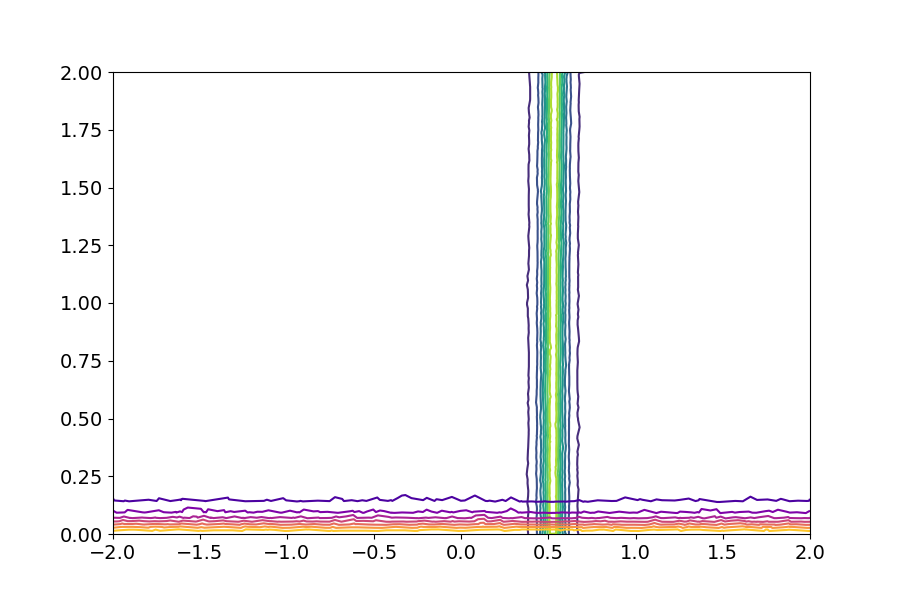

In [48]:
fig,ax = plt.subplots(figsize=(9,6))
plt.tricontour(lamr_s, lami_s, r_s)
plt.tricontour(lamr_s, lami_s, i_s, cmap='plasma')

In [120]:
alpha = 0.9
delta = 1
T = np.sqrt(1 - alpha)

lamr1 = []
lamr2 = []

lamis = np.arange(0.1, np.pi, 1e-3)

for lami in lamis:
    def f1(lamr):
        return 1 - 3*T**2 - alpha*np.exp(-delta*lamr)*np.cos(lami*delta) - lamr
    
    def f2(lamr):
        return alpha*np.exp(-delta*lamr)*np.sin(lami*delta) - lami
    
    lamr1.append(fsolve(f1, -2))
    lamr2.append(fsolve(f2, -2))    

/home/alessandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/alessandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


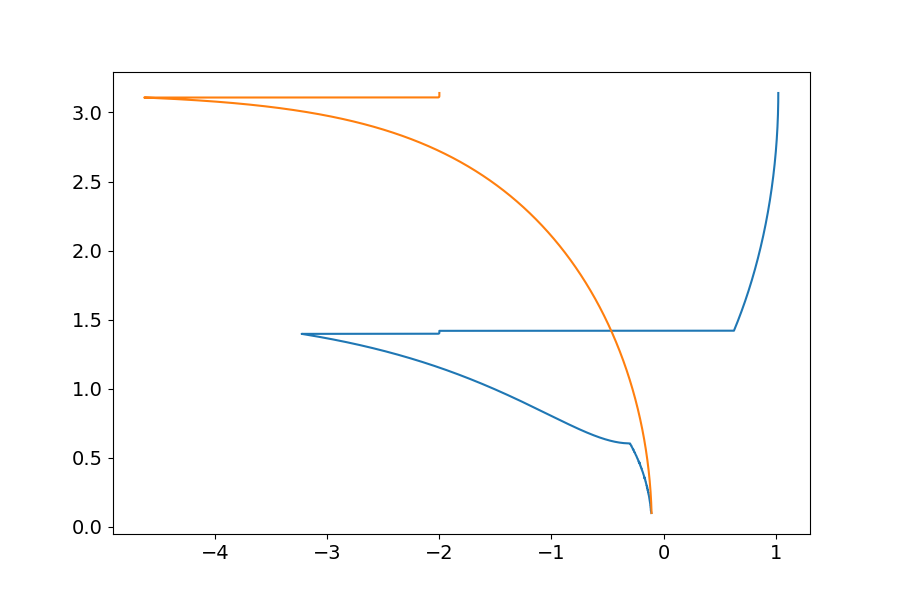

In [121]:
fig,ax = plt.subplots(figsize=(9,6))

plt.plot(lamr1, lamis)
plt.plot(lamr2, lamis)

# Defining the ENSO class

$\dfrac{\text{d}T(t)}{\text{d}t}=T(t)-\alpha T(t-\delta)-T(t)^3$

In [2]:
class ENSO():
    def __init__(self, alpha, delta, t0s, T0s, find_by_guess=True):
        '''
        ----------
        Parameters:
            alpha:
            delta:
            t0s: list of time points for the initialization
                required condition: t0s[-1] - t0s[0] > delta
            T0s: list of temperature values at the time points in t0s
            
            find_by_guess: whether to find the correct time by guess (based on the timestep) or by search (default True)
        '''
        
        self.alpha = alpha
        self.delta = delta
        
        # time series of time and temperature
        self.ts = list(t0s)
        self.Ts = list(T0s)
        
        self.find_by_guess = find_by_guess
        
    def T(self,t):
        '''
        Compute temperature at any time t by a linear interpolation of the time series
        
        '''
        if t < self.ts[0] or t > self.ts[-1]:
            raise IndexError('Outside of interpolation range')
            
        # find the nearest datapoint
        if self.find_by_guess:
            local_dt = self.ts[-1] - self.ts[-2]
            nearest_previous_t_index = int(max(0, len(self.ts) + (t - self.ts[-1])//local_dt - 2))
            while True:
                if self.ts[nearest_previous_t_index] < t:
                    if self.ts[nearest_previous_t_index + 1] >= t:
                        break
                    else:
                        nearest_previous_t_index += 1
                else:
                    nearest_previous_t_index -= 1
        
        else:
            nearest_previous_t_index = -1
            go_back_up_to = 1
            while nearest_previous_t_index == -1:
                go_back_up_to *= 10
                q = self.ts[-go_back_up_to:]
                nearest_previous_t_index = np.searchsorted(q,t) - 1

            nearest_previous_t_index = len(self.ts) - (len(q) - nearest_previous_t_index)
            
            
        # perform the linear interpolation
        t1 = self.ts[nearest_previous_t_index]
        T1 = self.Ts[nearest_previous_t_index]
        t2 = self.ts[nearest_previous_t_index + 1]
        T2 = self.Ts[nearest_previous_t_index + 1]
        
        return T1 + (t - t1)*(T2 - T1)/(t2 - t1)
    
    def __call__(self, t):
        '''
        Computes dT/dt at time t
        '''
        T = self.T(t)
        Td = self.T(t - self.delta)
        
        return T - self.alpha*Td - T**3
    
    
    def Euler(self, tmax, dt, show_progress_bar=True):
        '''
        Evolves the system with the Euler integration method (deterministic)
        
        $$
        dT = \\left( T(t)-\\alpha T(t-\\delta)-T(t)^3 \\right) dt
        $$
        
        -------
        Parameters:
            tmax: maximum t of the simulation
            dt: timestep
            show_progress_bar: wheteher to show a progress bar while the simulation is running (default True)
        '''
        new_points = np.arange(self.ts[-1], tmax, dt)
        
        for i in tqdm(range(1, len(new_points)), disable=not show_progress_bar):
            t_prev = new_points[i-1]
            T = self.T(t_prev)
            dT = self(t_prev)*dt
            
            new_t = new_points[i]
            new_T = T + dT
            
            self.ts.append(new_t)
            self.Ts.append(new_T)
    
    def Euler_Maruyama(self, tmax, dt, sigma, show_progress_bar=True):
        '''
        Evolves the system with the Euler-Maruyama integration method (stochastic)
        
        $$
        dT = \\left( T(t)-\\alpha T(t-\\delta)-T(t)^3 \\right) dt + \\sigma dW
        $$
        -------
        Parameters:
            tmax: maximum t of the simulation
            dt: timestep
            sigma: amplitude of the gaussian noise
            show_progress_bar: wheteher to show a progress bar while the simulation is running (default True)
        '''
        new_points = np.arange(self.ts[-1], tmax, dt)
        
        for i in tqdm(range(1, len(new_points)), disable=not show_progress_bar):
            t_prev = new_points[i-1]
            T = self.T(t_prev)
            dT = self(t_prev)*dt + sigma*np.sqrt(dt)*np.random.normal()
            
            new_t = new_points[i]
            new_T = T + dT
            
            self.ts.append(new_t)
            self.Ts.append(new_T)
    
    
    def plot(self, show_attractor=True, ax=None, label=None, figsize=(9,6)):
        '''
        Plots the time series and returns fig,ax
        
        ----------
        Parameters:
            show_attractor: whether to show the attractor in the limit delta -> 0 (default True)
            ax: axis on where to plot. If None (default) a new one is created
            label: label to put on the plot
            figsize: default (9,6)
        '''
        fig = None
        if ax is None:
            fig,ax = plt.subplots(figsize=figsize)
        ax.plot(self.ts, self.Ts, label=label)
        ax.set_xlabel('t')
        ax.set_ylabel('T')
        if label:
            plt.legend()

        if show_attractor:
            ax.set_xlim(*ax.get_xlim())
            
            if self.alpha < 1:
                ax.hlines([np.sqrt(1 - self.alpha), -np.sqrt(1 - self.alpha)],
                          *ax.get_xlim(), color='black', linestyle='dotted') 
            else:
                ax.hlines([0], *ax.get_xlim(), color='black', linestyle='dotted')
                
        if fig:
            fig.tight_layout()
        
        return fig,ax

# Testing

In [140]:
matplotlib.rc('font', size=18)

  0%|          | 0/99999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


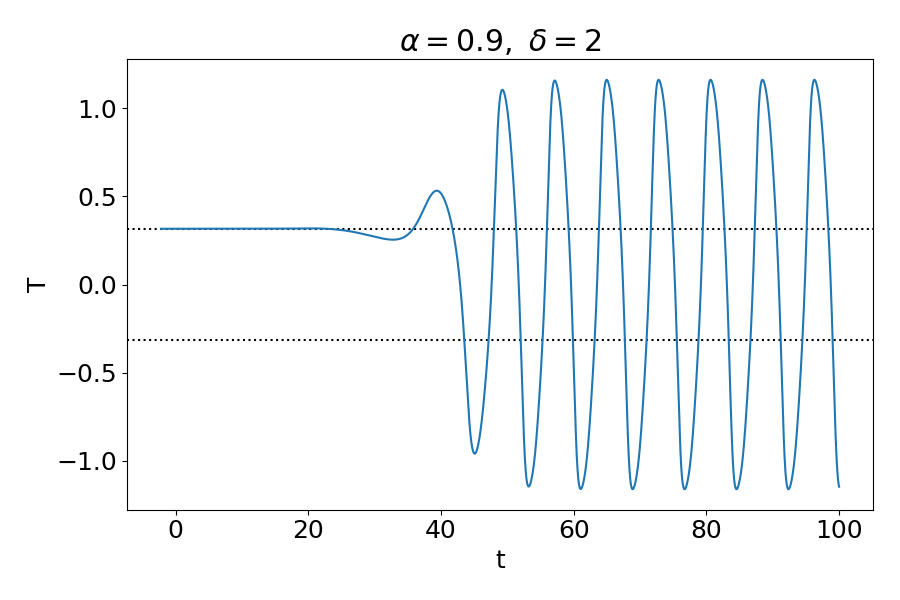

In [145]:
alpha = 0.9
delta = 2
epsilon = 1e-5
T0 = np.sqrt(1-alpha) + epsilon
# T0 = 0.001

e = ENSO(alpha=alpha, delta=delta,
         t0s=[-1.1*delta,0], T0s=[T0]*2,
#          t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
#          find_by_guess=False
        )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler(tmax=100, dt=0.001, show_progress_bar=True)
fig,ax = e.plot()

plt.title(r'$\alpha = %.1f , \ \delta = %d$' %(alpha, delta))

# ax.hlines([np.sqrt(1 + alpha), -np.sqrt(1 + alpha)],
#                           *ax.get_xlim(), color='black', linestyle='dotted') 

fig.tight_layout()

In [146]:
fig.savefig('deterministic_alpha0.9_delta2.pdf')

## Checking dependence on dt

<IPython.core.display.Javascript object>


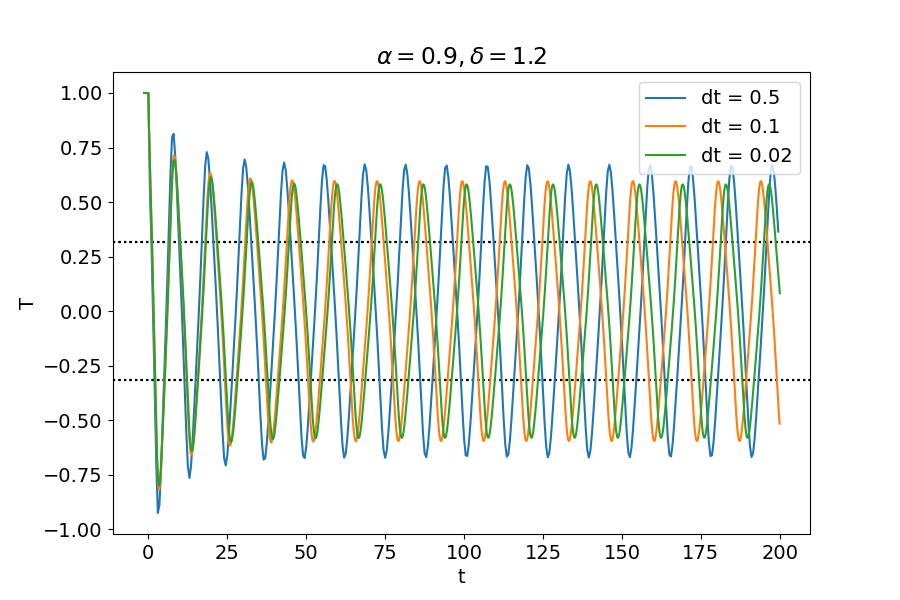

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

Text(0.5, 1.0, '$\\alpha=0.9, \\delta=1.2$')

In [195]:
alpha=0.9
delta = 1.2
tmax = 200
T0 = 1

dts = [5e-1, 1e-1, 2e-2]

fig,ax = plt.subplots(figsize=(9,6))

for dt in dts:
    e = ENSO(alpha=alpha, delta=delta,
             t0s=[-1.1*delta,0], T0s=[T0]*2,
            )
    e.Euler(tmax=tmax, dt=dt)
    
    e.plot(ax=ax, label=f'{dt = }')
    
plt.title(r'$\alpha=%.1f, \delta=%.1f$' %(alpha,delta))

In [196]:
fig.savefig('dt_dependence_supercritical.pdf')

# Critical delta

In [13]:
def delta_crit(alpha):
    if alpha < 1:
        return np.arccos((3*alpha - 2)/alpha)/np.sqrt(alpha**2 - (2 - 3*alpha)**2)
    elif alpha == 1:
        return 1.
    else:
        return np.arccos(1./alpha)/np.sqrt(alpha**2 - 1)

In [148]:
delta_crit(0.9)

1.2015049158624418

<IPython.core.display.Javascript object>


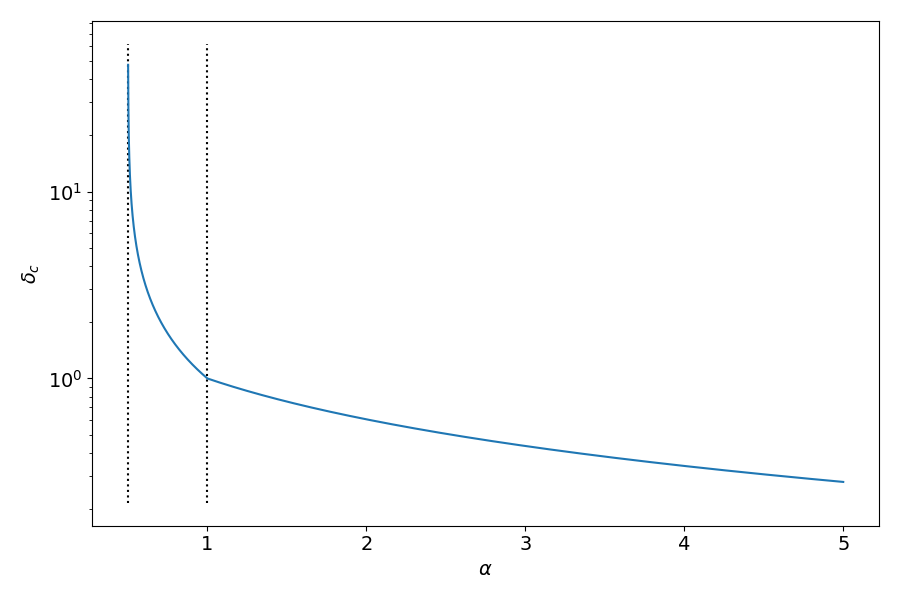

In [5]:
alphas = np.arange(0.501,5,0.0001)
delta_crits = [delta_crit(alpha) for alpha in alphas]

fig,ax = plt.subplots(figsize=(9,6))
plt.semilogy(alphas, delta_crits)

plt.vlines([0.5, 1], *ax.get_ylim(), color='black', linestyles='dotted')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta_{c}$')

fig.tight_layout()

In [6]:
fig.savefig('delta_crit_vs_alpha_extended.pdf')

## Defining the variance function

In [197]:
alpha = 0.9
epsilon = 1e-3
tmax = 500
dt = 0.01

T0 = np.sqrt(1-alpha) + epsilon

def var(delta):
    e = ENSO(alpha=0.9, delta=delta,
             t0s=[-1.1*delta,0], T0s=[T0]*2,
            )
    e.Euler(tmax=tmax, dt=dt, show_progress_bar=False)
    
    v = np.var(e.Ts)
    return v

## 1D variance plot

In [198]:
learner = adaptive.Learner1D(var, bounds=[1,2])

In [199]:
runner = adaptive.Runner(learner, goal = lambda l: l.loss() < 0.01)
runner.live_info()

<IPython.core.display.Javascript object>


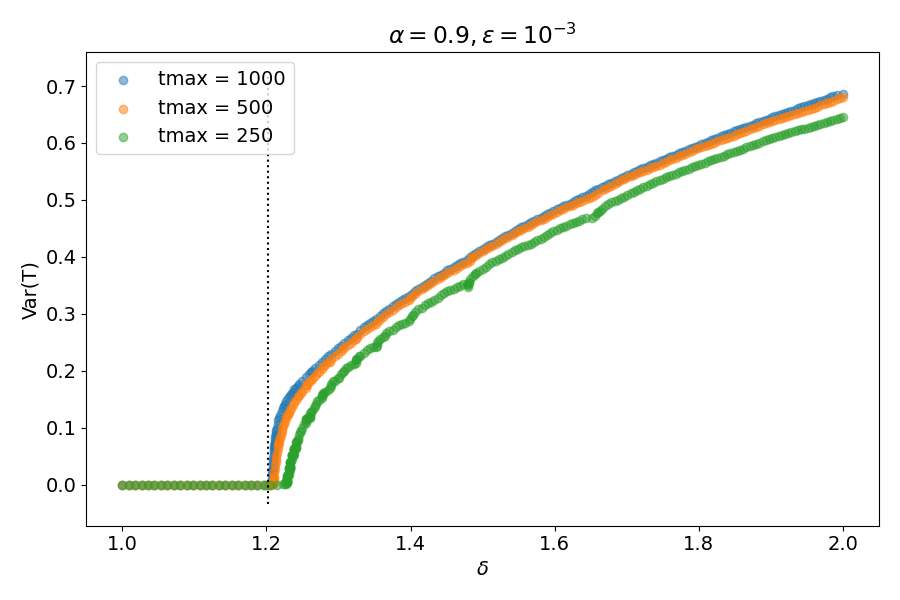

In [200]:
x = learner.data.keys()
y = learner.data.values()

x2 = learner2.data.keys()
y2 = learner2.data.values()

x3 = learner3.data.keys()
y3 = learner3.data.values()

fig,ax = plt.subplots(figsize=(9,6))
plt.scatter(x,y, alpha=0.5, label='tmax = 1000')
plt.scatter(x2,y2, alpha=0.5, label='tmax = 500')
plt.scatter(x3,y3, alpha=0.5, label='tmax = 250')
plt.title(r'$\alpha = %.1f, \epsilon = 10^{%d}$' %(alpha,np.log10(epsilon)))

# plt.scatter(x,y, alpha=0.5, label=r'$\epsilon = 10^{-5}$')
# plt.scatter(x2,y2, alpha=0.5, label=r'$\epsilon = 10^{-4}$')
# plt.scatter(x3,y3, alpha=0.5, label=r'$\epsilon = 10^{-3}$')
# plt.title(r'$\alpha = %.1f$, tmax = %d' %(alpha,tmax))


plt.xlabel(r'$\delta$')
plt.ylabel('Var(T)')

plt.vlines(delta_crit(alpha), *ax.get_ylim(), color='black', linestyles='dotted')

plt.legend()



fig.tight_layout()

In [165]:
fig.savefig('varT_vs_delta-varying_tmax.pdf')

## 2D variance plot

In [201]:
epsilon = 1e-3
def var2d(delta_alpha):
#     print(delta_alpha)
    delta, alpha = delta_alpha
    if alpha > 1:
        T0 = epsilon
    else:
        T0 = np.sqrt(1 - alpha) + epsilon
    e = ENSO(alpha=alpha, delta=delta,
       t0s=[-1.1*delta,0], T0s=[T0]*2,
      )
    e.Euler(tmax=1000, dt=0.02, show_progress_bar=False)
    
    v = np.var(e.Ts[-int(10000):])
    return v

In [202]:
learner = adaptive.Learner2D(var2d, bounds=[(0.1, 10), (0, 2)])

In [203]:
runner = adaptive.Runner(learner, goal = lambda l: l.loss() < 0.005)
runner.live_info()

In [7]:
learner.plot()

:Overlay
   .Image.I     :Image   [x,y]   (z)
   .EdgePaths.I :EdgePaths   [x,y]

In [204]:
xy = np.array(list(learner.data.keys()))
deltas, alphas = xy[:,0], xy[:,1]
vs = np.array(list(learner.data.values()))

In [81]:
var2d((0.5,0.5))

2.666673970537505e-05

<IPython.core.display.Javascript object>


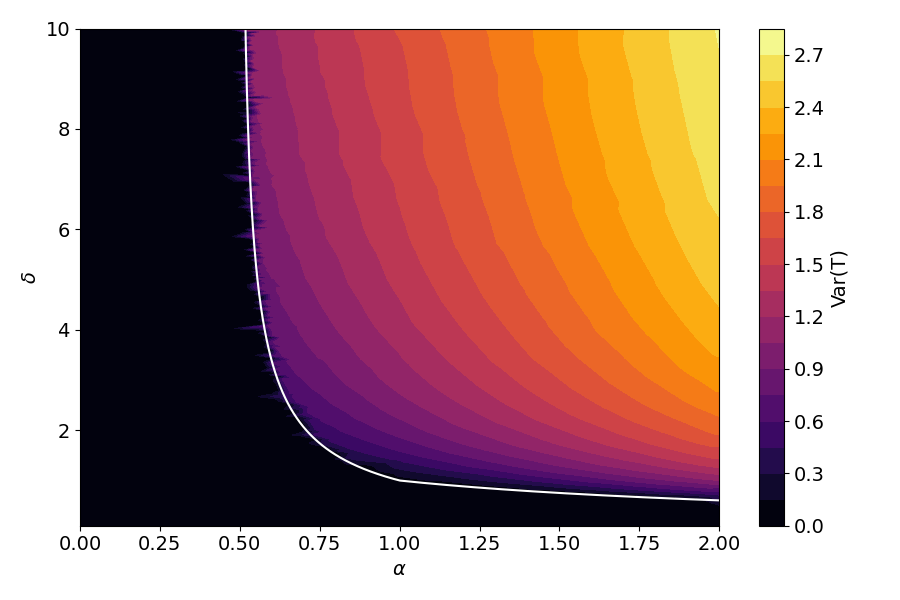

In [205]:
fig,ax = plt.subplots(figsize=(9,6))

plt.tricontourf(alphas, deltas, vs, cmap='inferno', levels=20)
plt.colorbar(label='Var(T)')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(*ax.get_ylim())

# plt.scatter(alphas, deltas)

alpha_s = np.arange(0.501,5,0.0001)
delta_crits = [delta_crit(alpha) for alpha in alpha_s]

plt.plot(alpha_s, delta_crits, color='white',
#          linestyle='dotted',
        )

fig.tight_layout()

In [206]:
fig.savefig('alpha_delta_contour_superimposed_dt0.02.pdf')

# Stochastic Dynamics

  0%|          | 0/499999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


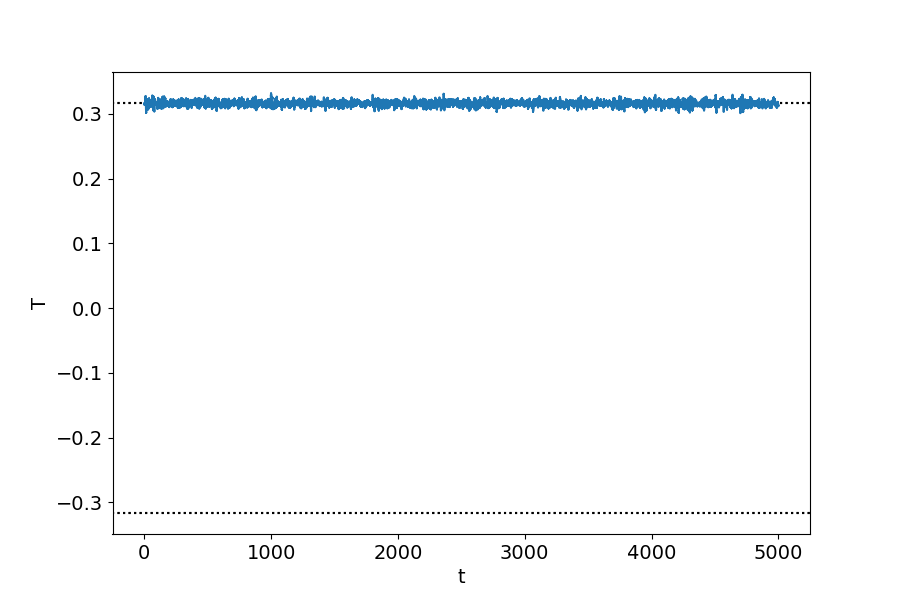

In [211]:
alpha = 0.9
delta = 1
epsilon = 0
T0 = np.sqrt(1-alpha) + epsilon
sigma = 1e-3

e = ENSO(alpha=alpha, delta=delta,
       t0s=[-1.1*delta,0], T0s=[T0]*2,
#        t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
      )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler_Maruyama(tmax=5000, dt=0.01, sigma=sigma)
fig,ax = e.plot()

ax.hlines([np.sqrt(1 - alpha), -np.sqrt(1 - alpha)], *ax.get_xlim(), color='black', linestyle='dotted')

In [3]:
matplotlib.rc('font', size=20)

In [43]:
alpha = 0.9
delta = 2
epsilon = 0
T0 = np.sqrt(1-alpha) + epsilon
sigma = 3e-2

e = ENSO(alpha=alpha, delta=delta,
       t0s=[-1.1*delta,0], T0s=[T0]*2,
#        t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
      )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler_Maruyama(tmax=10000, dt=0.02, sigma=sigma)

  0%|          | 0/499999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


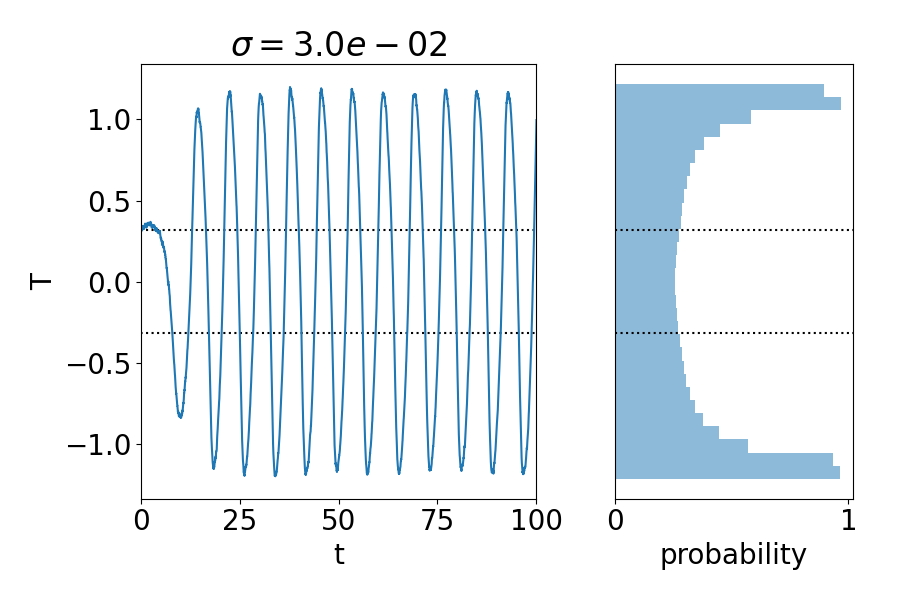

In [44]:
fig = plt.figure(figsize=(9,6))
gs = GridSpec(4,5)

ax_plot = fig.add_subplot(gs[:,0:3])
ax_hist = fig.add_subplot(gs[:,3:])

ax_plot.plot(np.array(e.ts), e.Ts)
ax_plot.set_xlim(ax_plot.get_xlim())
ax_plot.hlines([np.sqrt(1 - alpha), -np.sqrt(1 - alpha)], *ax_plot.get_xlim(), color='black', linestyle='dotted')

ax_hist.set_ylim(*ax_plot.get_ylim())
ax_hist.hist(e.Ts, bins=30, orientation='horizontal', alpha=0.5, density=True)
ax_hist.set_xlim(ax_hist.get_xlim())
ax_hist.hlines([np.sqrt(1 - alpha), -np.sqrt(1 - alpha)], *ax_hist.get_xlim(), color='black', linestyle='dotted')

ax_hist.get_yaxis().set_ticks([])

ax_plot.set_xlabel('t')
ax_plot.set_ylabel('T')
ax_hist.set_xlabel('probability')

ax_plot.set_xlim(0, 100)

ax_plot.set_title(r'$\sigma=%.1e$' %sigma)

fig.tight_layout()

In [45]:
fig.savefig('essential/delta%d_sigma%.1e.pdf' % (delta, sigma))

<IPython.core.display.Javascript object>


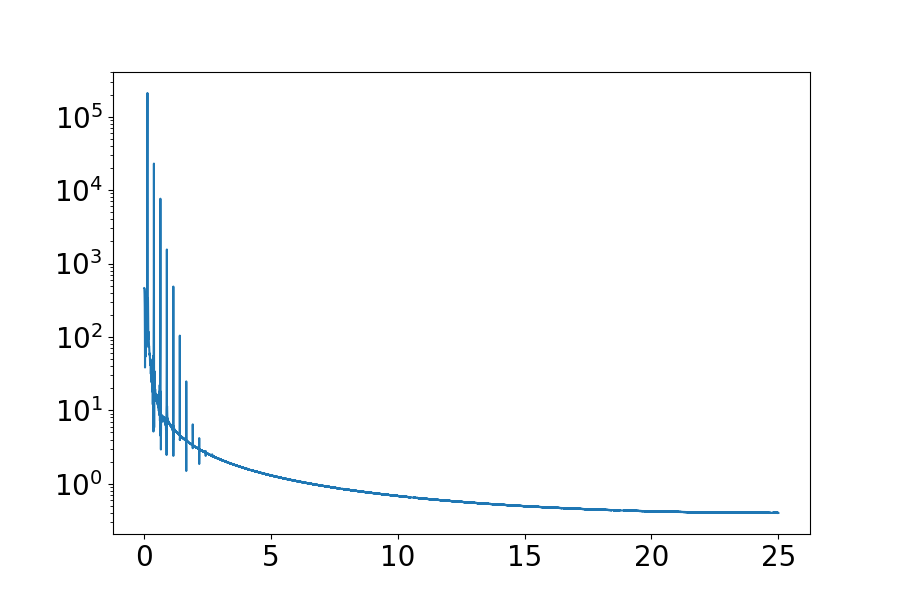

3.9177194354658784


In [279]:
fig,ax = plt.subplots(figsize=(9,6))

fft = np.fft.fft(e.Ts[100:])
freq = np.fft.fftfreq(len(e.ts[100:]), d=e.ts[-1]-e.ts[-2])

fft = fft[:len(fft)//2]
freq = freq[:len(freq)//2]

period = 1/(freq[np.argmax(np.abs(fft))])

print(period/delta)

plt.semilogy(freq, np.abs(fft))

# Fourier Analysis

In [46]:
matplotlib.rc('font', size=20)

  0%|          | 0/99999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


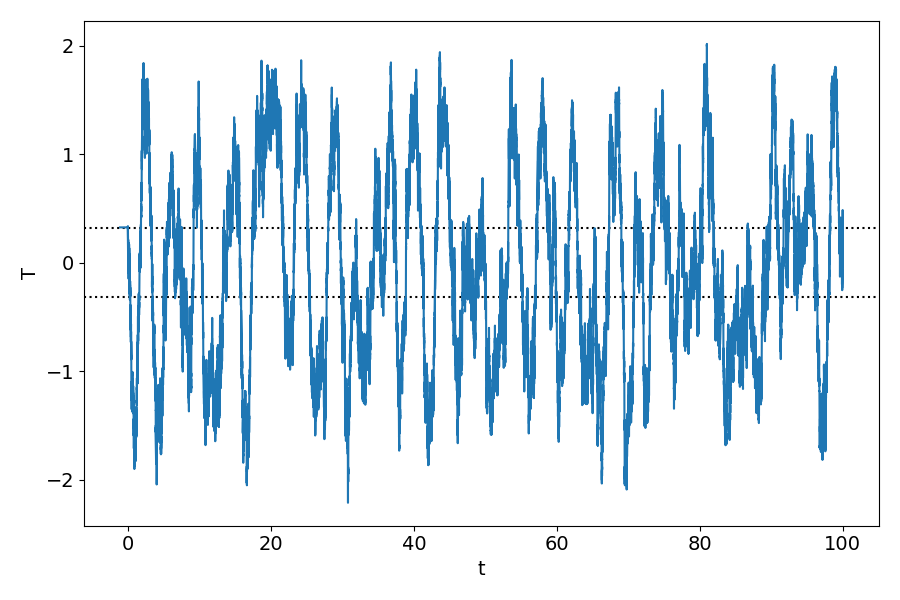

In [100]:
alpha = 0.9
delta = 1
epsilon = 1e-2
T0 = np.sqrt(1-alpha) + epsilon
# T0 = 0.1

e = ENSO(alpha=alpha, delta=delta,
         t0s=[-1.1*delta,0], T0s=[T0]*2,
#          t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
#          find_by_guess=False
        )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler_Maruyama(tmax=100*delta, dt=0.001, sigma=1e-0,
                 show_progress_bar=True)
fig,ax = e.plot()

<IPython.core.display.Javascript object>


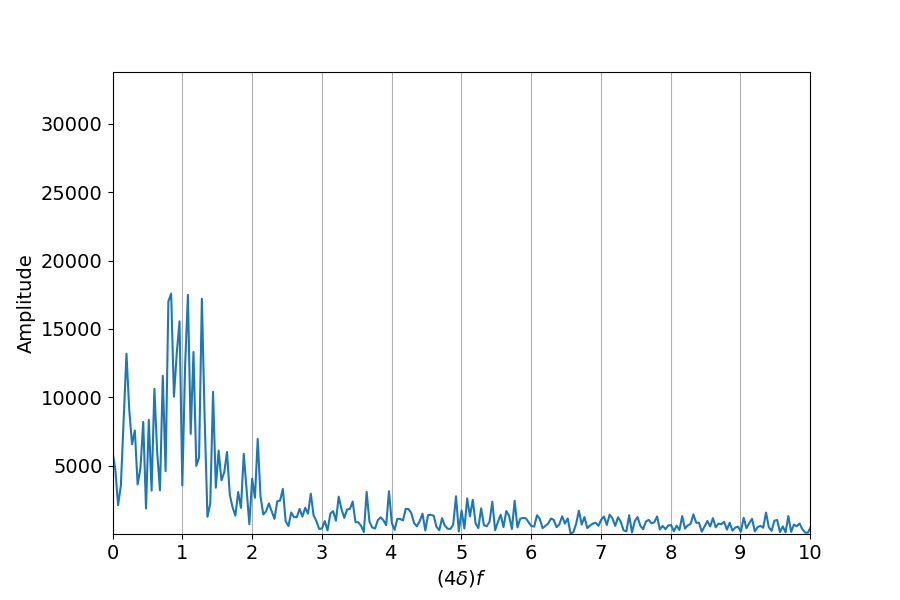

4.7571904761455865


Text(0, 0.5, 'Amplitude')

In [102]:
fig,ax = plt.subplots(figsize=(9,6))

fft = np.fft.fft(e.Ts[100:])
freq = np.fft.fftfreq(len(e.ts[100:]), d=e.ts[-1]-e.ts[-2])

fft = fft[:len(fft)//2]
freq = freq[:len(freq)//2]

period = 1/(freq[np.argmax(np.abs(fft))])

print(period/delta)

plt.semilogy(freq*(4*delta), np.abs(fft))

ax.set_ylim(*ax.get_ylim())

# ax.vlines(np.arange(40)/(4*delta), *ax.get_ylim(), color='black', linestyle='dotted')

plt.xlim(0,10)
plt.xticks(np.arange(11))
plt.grid(axis='x')

plt.xlabel(r'$(4\delta) f$')
plt.ylabel('Amplitude')

## Spectrum as delta varies

In [112]:
alpha = 0.9
# deltas = np.arange(0.1, 20, 0.1)
deltas = np.arange(0.5, 2, 0.01)
epsilon = 1e-2
T0 = np.sqrt(1-alpha) + epsilon
sigma = 1e-0


ffts = []
freqs = []
delta_s = []

for delta in tqdm(deltas):
    e = ENSO(alpha=alpha, delta=delta,
             t0s=[-1.1*delta,0], T0s=[T0]*2,
            )
    if sigma == 0:
        e.Euler(tmax=100*delta, dt=0.02,
                show_progress_bar=False)
    else:
        e.Euler_Maruyama(tmax=500*delta, dt=0.02, sigma=sigma,
                         show_progress_bar=False)
    
    max_freq = 2/delta
    
    fft = np.abs(np.fft.fft(e.Ts[100:]))
    freq = np.fft.fftfreq(len(e.ts[100:]), d=e.ts[-1]-e.ts[-2])

    fft = fft[1:len(fft)//2]
    freq = freq[1:len(freq)//2]
    
    freq = freq[freq < max_freq]
    fft = fft[:len(freq)]
    
    ffts += list(fft)
    freqs += list(freq)
    delta_s += [delta]*len(fft)


  0%|          | 0/150 [00:00<?, ?it/s]

In [113]:
freqs = np.array(freqs)
delta_s = np.array(delta_s)
ffts = np.array(ffts)

<IPython.core.display.Javascript object>


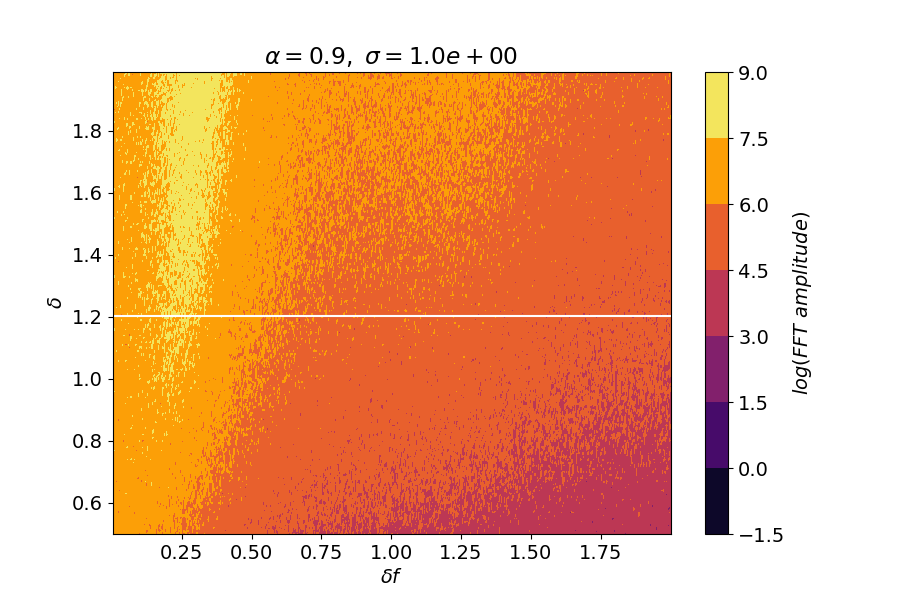

Text(0.5, 1.0, '$\\alpha = 0.9, \\ \\sigma = 1.0e+00$')

In [117]:
fig,ax = plt.subplots(figsize=(9,6))

plt.tricontourf((freqs*delta_s), delta_s, np.log(ffts), cmap='inferno')
# plt.xlim(0,6)

# plt.vlines(0.5 + np.arange(10), *ax.get_ylim(), color='white', linestyles='dotted')
plt.hlines([delta_crit(alpha)], *ax.get_xlim(), color='white')

# plt.ylim(0.4, ax.get_ylim()[1])

plt.xlabel(r'$\delta f$')
plt.ylabel(r'$\delta$')

plt.colorbar(label='$log(FFT\ amplitude)$')
plt.title(r'$\alpha = %.1f, \ \sigma = %.1e$' % (alpha,sigma))

In [85]:
fig.savefig('fft_vs_delta_zoom_sigma%.4f.pdf' %sigma)

### Do all at once

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


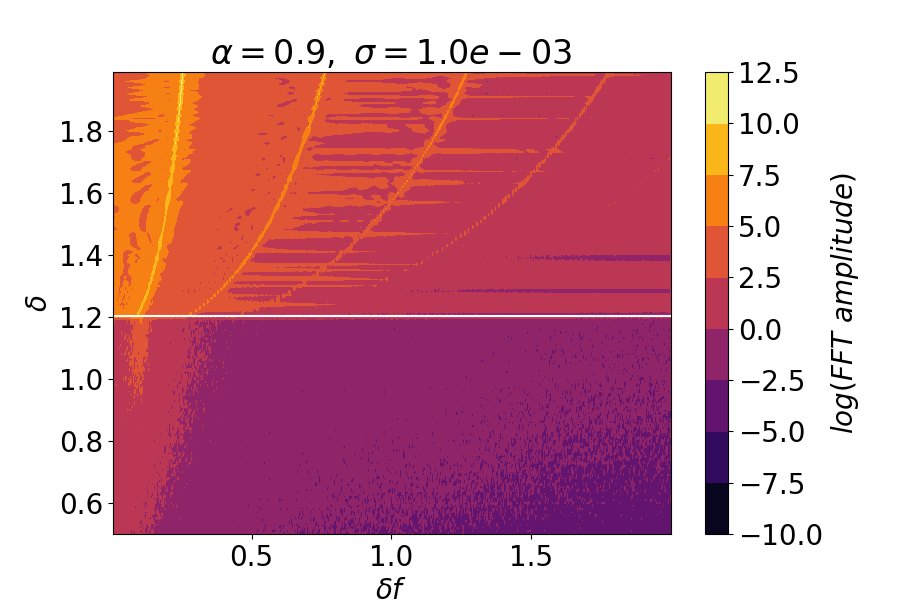

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


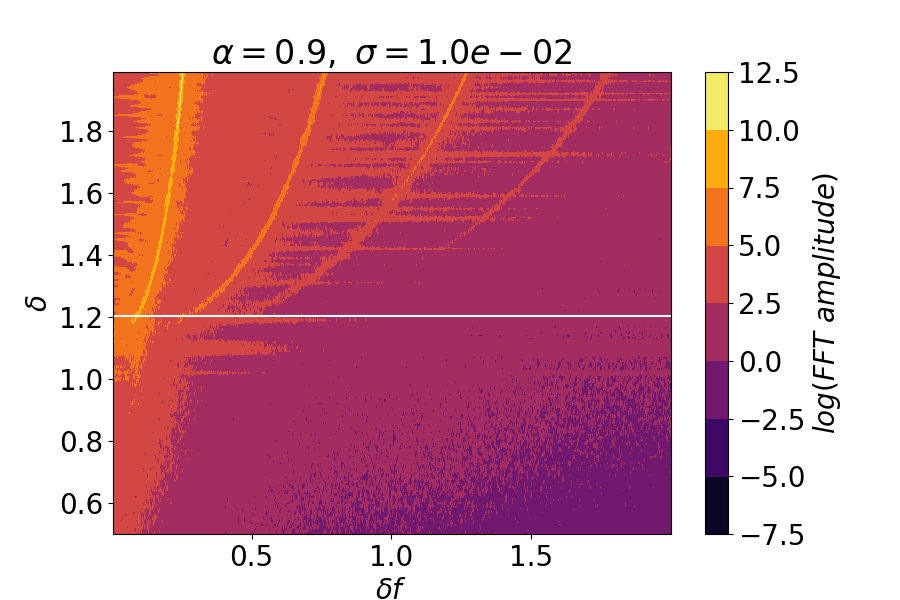

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


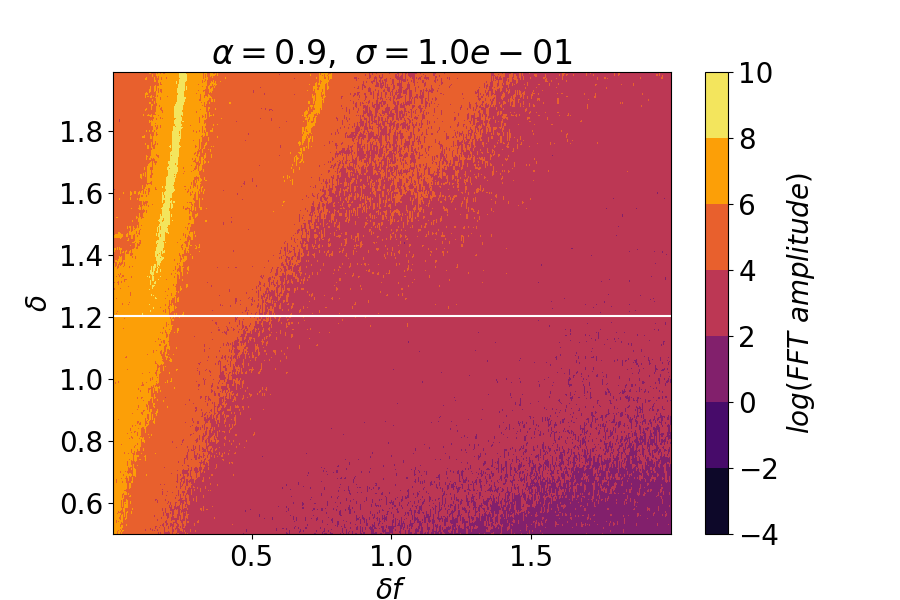

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


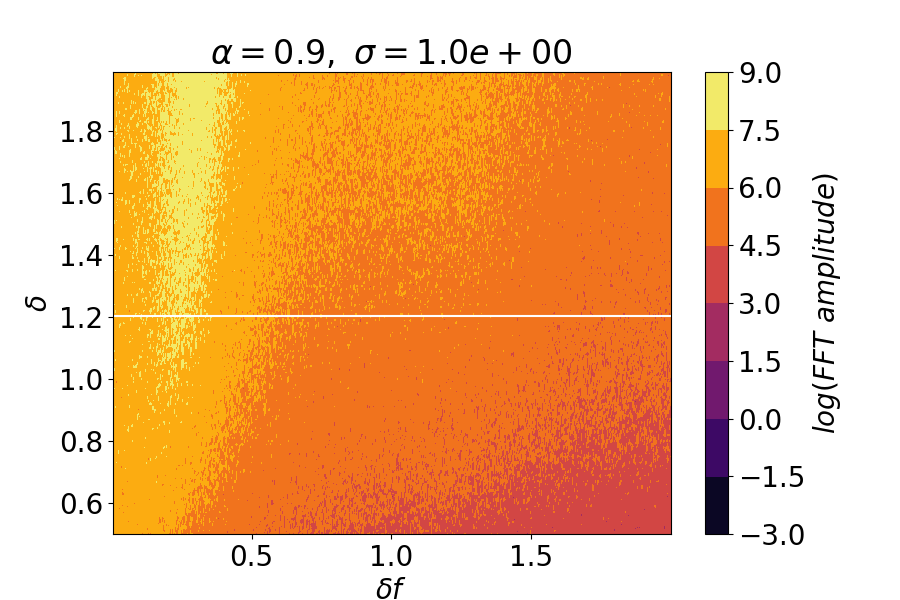

In [49]:
sigmas = [1e-3, 1e-2, 1e-1, 1]

for sigma in sigmas:
    alpha = 0.9
    # deltas = np.arange(0.1, 20, 0.1)
    deltas = np.arange(0.5, 2, 0.01)
    epsilon = 1e-2
    T0 = np.sqrt(1-alpha) + epsilon


    ffts = []
    freqs = []
    delta_s = []

    for delta in tqdm(deltas):
        e = ENSO(alpha=alpha, delta=delta,
                 t0s=[-1.1*delta,0], T0s=[T0]*2,
                )
        if sigma == 0:
            e.Euler(tmax=100*delta, dt=0.02,
                    show_progress_bar=False)
        else:
            e.Euler_Maruyama(tmax=500*delta, dt=0.02, sigma=sigma,
                             show_progress_bar=False)

        max_freq = 2/delta

        fft = np.abs(np.fft.fft(e.Ts[100:]))
        freq = np.fft.fftfreq(len(e.ts[100:]), d=e.ts[-1]-e.ts[-2])

        fft = fft[1:len(fft)//2]
        freq = freq[1:len(freq)//2]

        freq = freq[freq < max_freq]
        fft = fft[:len(freq)]

        ffts += list(fft)
        freqs += list(freq)
        delta_s += [delta]*len(fft)
        
    freqs = np.array(freqs)
    delta_s = np.array(delta_s)
    ffts = np.array(ffts)
    
    fig,ax = plt.subplots(figsize=(9,6))

    plt.tricontourf((freqs*delta_s), delta_s, np.log(ffts), cmap='inferno')
    # plt.xlim(0,6)

    # plt.vlines(0.5 + np.arange(10), *ax.get_ylim(), color='white', linestyles='dotted')
    plt.hlines([delta_crit(alpha)], *ax.get_xlim(), color='white')

    # plt.ylim(0.4, ax.get_ylim()[1])

    plt.xlabel(r'$\delta f$')
    plt.ylabel(r'$\delta$')

    plt.colorbar(label='$log(FFT\ amplitude)$')
    plt.title(r'$\alpha = %.1f, \ \sigma = %.1e$' % (alpha,sigma))

    fig.savefig('essential/fft_vs_delta_zoom_sigma%.4f.pdf' %sigma)

## Period vs alpha and delta

In [228]:
epsilon = 1e-2
sigma = 0

def tau(alphadeltae):
    alpha, deltae = alphadeltae
    
    delta = (delta_crit(0.505) - delta_crit(alpha))*deltae + delta_crit(alpha)
    
    T0 = np.sqrt(1-alpha) + epsilon
    
    e = ENSO(alpha=alpha, delta=delta,
             t0s=[-1.1*delta,0], T0s=[T0]*2,
            )
    if sigma == 0:
        e.Euler(tmax=500*delta, dt=0.02,
                show_progress_bar=False)
    else:
        e.Euler_Maruyama(tmax=500*delta, dt=0.02, sigma=sigma,
                         show_progress_bar=False)
    
    max_freq = 2/delta
    
    fft = np.abs(np.fft.fft(e.Ts[100:]))
    freq = np.fft.fftfreq(len(e.ts[100:]), d=e.ts[-1]-e.ts[-2])

    fft = fft[:len(fft)//2]
    freq = freq[:len(freq)//2]
    
    freq = freq[freq < max_freq]
    fft = fft[:len(freq)]
    
    period = freq[np.argmax(fft)]
    
    return period
    

In [229]:
learner = adaptive.Learner2D(tau, bounds=[(0.51, 1), (0.1, 1)])

In [240]:
runner = adaptive.Runner(learner, goal = lambda l: l.loss() < 0.0005)
runner.live_info()

In [241]:
xy = np.array(list(learner.data.keys()))
deltaes, alphas = xy[:,1], xy[:,0]

delta_crits = np.array([delta_crit(alpha) for alpha in alphas])
deltas = (delta_crit(0.505) - delta_crits)*deltaes + delta_crits

vs = np.array(list(learner.data.values()))

<IPython.core.display.Javascript object>


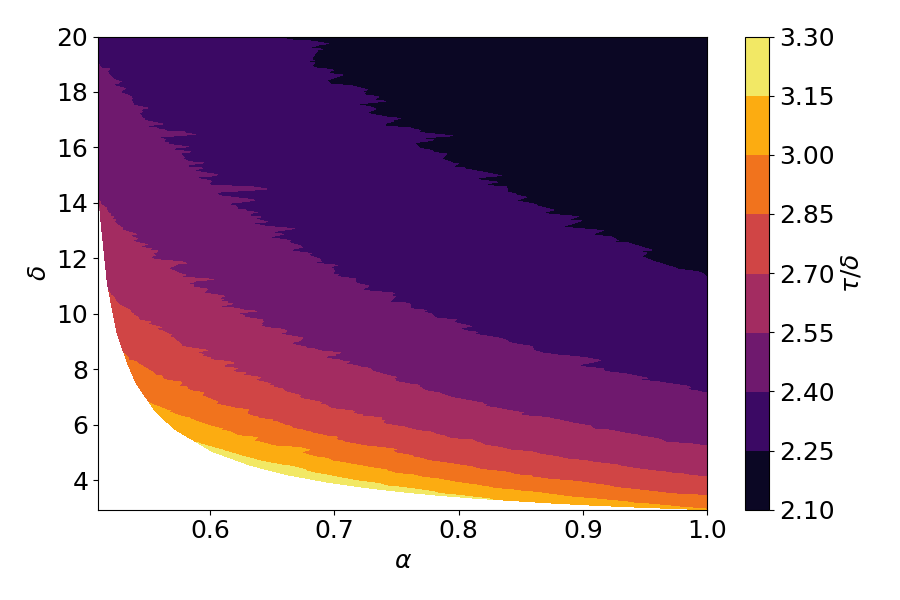

In [250]:
fig,ax = plt.subplots(figsize=(9,6))

plt.tricontourf(alphas, deltas, 1/(vs*deltas), cmap='inferno', levels=10)
plt.colorbar(label=r'$\tau/\delta$')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(ax.get_ylim()[0], 20)

# plt.scatter(alphas, deltas)

alpha_s = np.arange(0.501,1,0.0001)
delta_crits = [delta_crit(alpha) for alpha in alpha_s]

plt.plot(alpha_s, delta_crits, color='white',
#          linestyle='dotted',
        )

fig.tight_layout()

In [251]:
fig.savefig('tau_vs_alpha_delta.pdf')